## Analysis Based on the Observations Below

**Initial Inspection of the Data:**
* The login dates/times were not sorted in the raw data. Therefore, the data was sorted chronologically prior to performing any further analysis.
* There were no missing/null values in the data. 
* All dates were properly formatted, as the 'login_time' column was recognized as datetime data by Pandas
* The start date was Jan. 1st, 1970 and the end date was Apr. 13th, 1970. There was data for each day within those bounds, so there were no missing dates. 

**Daily Login Trends:**
* Looking at daily login trends over the entire time period, the data appeared to be cyclical. The cycles appeared to be approximately 1 week in length, but further analysis was needed. Therefore, logins by day of the week were examined next.
* Login counts were much higher on weekends compared to weekdays (with the exception of Friday, which had comparable login counts to weekends). Monday had the lowest login counts. Logins gradually increased each day from Monday - Thursday. There was then a spike in login activity from Friday-Sunday, with Saturday and Sunday having the highest login counts.

**Login Trends in 15-minute Time Intervals:**
* The login trends over the course of each week were then examined. In general, there tended to be two spikes in login activity each day. One spike tended to appear around midnight and the other spike tended to occur around noon. Logins by time of day were examined next to get a finer-grained look at intraday login trends.
* Looking at logins by time of day, there tended to be a spike in logins from 9PM - 5AM and another spike from 11AM - 1PM. However, there may have been differences between weekday and weekend login patterns. This was examined next.
* Weekends tended to have only a single spike in login activity, between midnight and 5AM.
* Weekdays, on the other hand, tended to have a spike in login activity from 9PM - 2AM, and another spike from 11AM - 1PM

**Other Observations:**
* Looking at the daily trends, the peak number of logins tended to grow over the course of the time period (Jan 1st 1970 - April 13th 1970). This may have been due to growth in the number of users, a seasonal trend, or randomness. Without more data it is difficult to analyze this further.

## Imports and Useful Functions

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def label_figure(ax, title, x_label, y_label):
    ax.set_title(title);
    ax.set_xlabel(x_label);
    ax.set_ylabel(y_label);

## Gather Data

In [3]:
#read the data into pandas
file_path = 'logins.json'
df_logins = pd.read_json(file_path)

## Initial Inspection of the Data

In [4]:
#examine the data
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
#ensure the data is sorted by date
df_logins = df_logins.sort_values(by='login_time').reset_index(drop=True)
df_logins.head()

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37


In [6]:
#inspect datatypes and check for nulls
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [7]:
#summary stats
df_logins.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648279
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


## Inspect Daily Data

In [8]:
#create a separate date column
df_logins['login_date'] = df_logins.login_time.dt.date
df_logins.head()

,login_time,login_date
0,1970-01-01 20:12:16,1970-01-01
1,1970-01-01 20:13:18,1970-01-01
2,1970-01-01 20:16:10,1970-01-01
3,1970-01-01 20:16:36,1970-01-01
4,1970-01-01 20:16:37,1970-01-01


In [9]:
#get daily login data
data_by_day= df_logins.groupby('login_date') \
    .agg({'login_time':'count'}) \
    .reset_index() \
    .rename(columns={'login_time':'login_count'})

data_by_day.login_date = pd.to_datetime(data_by_day.login_date)

In [10]:
#are there any missing dates within the date range?

#get first and last date in the dataset
start_date = df_logins.login_date.min()
end_date = df_logins.login_date.max()

#get all dates from start to end date (inclusive)
all_dates = pd.date_range(start_date,end_date)

#check the difference between the login dates and the all_dates list
print('Number of missing dates:' , len(all_dates.difference(data_by_day.login_date)))

Number of missing dates: 0


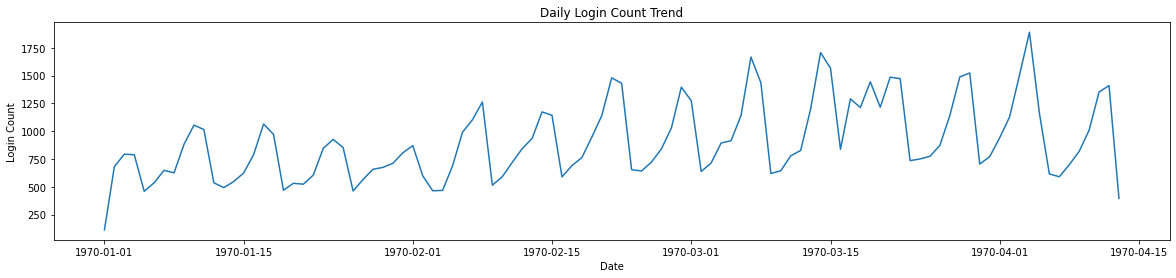

In [11]:
#inspect daily logins
plt.figure(figsize=(20, 4))
plt.plot(data_by_day.login_date, data_by_day.login_count);

#label the figure
label_figure(plt.gca(), 'Daily Login Count Trend', 'Date', 'Login Count')

In [12]:
#create a day of the week column
data_by_day['day_of_week'] = data_by_day.login_date.dt.dayofweek

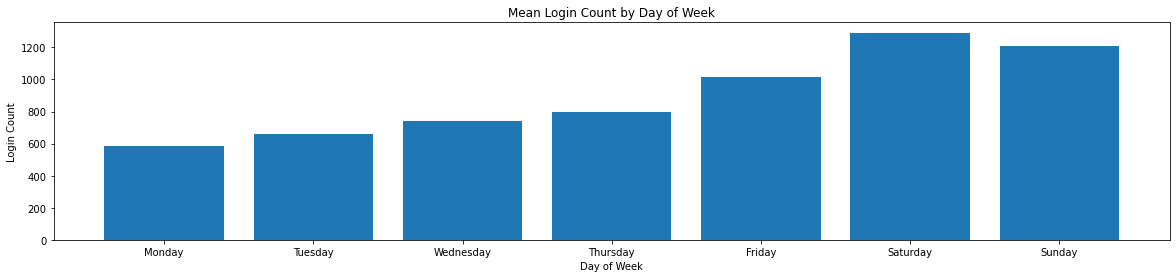

In [13]:
#examine login trends by day of the week

day_of_week_labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

#data by day of week
data_by_weekday = data_by_day.groupby('day_of_week') \
    .agg({'login_count':'mean'}) \
    .reset_index()

#plot logins by day
plt.figure(figsize=(20,4))
plt.bar(data_by_weekday.day_of_week, data_by_weekday.login_count);
plt.xticks(data_by_weekday.day_of_week, day_of_week_labels);
label_figure(plt.gca(), 'Mean Login Count by Day of Week', 'Day of Week', 'Login Count')

## Inspect Data by 15 Minute Intervals

In [14]:
#get data grouped by 15 minute intervals

#define a Grouper for 15 minute intervals
grouper = pd.Grouper(key='login_time',freq='15Min')

#group the data using the grouper
data_by_fifteen_mins = df_logins.groupby(grouper) \
    .count() \
    .reset_index() \
    .rename(columns={'login_date':'login_count'})

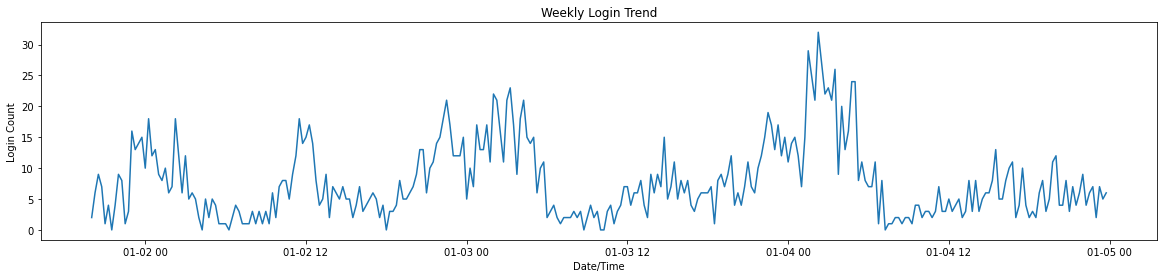

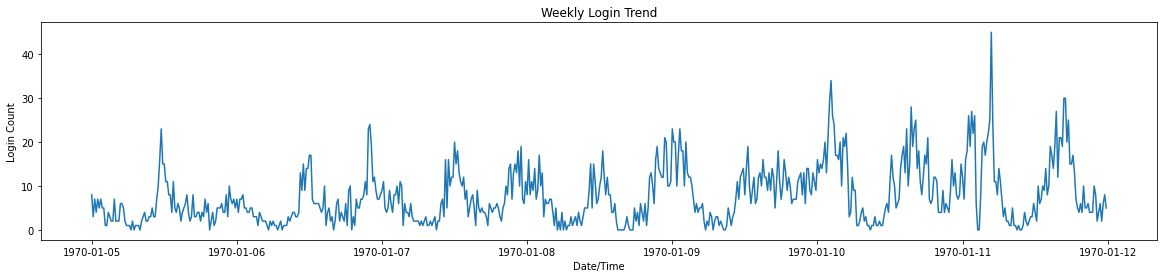

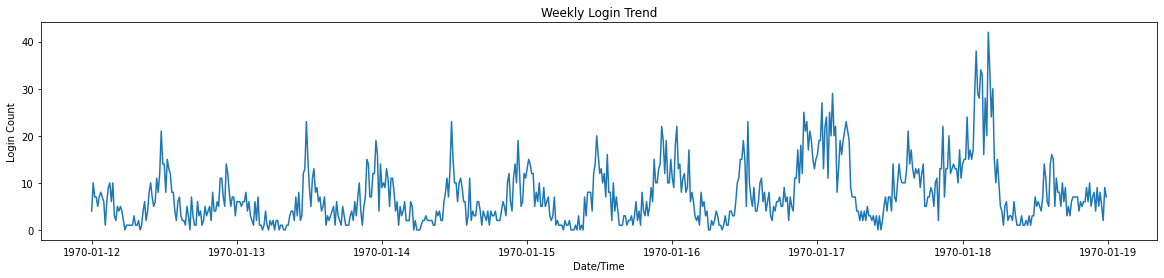

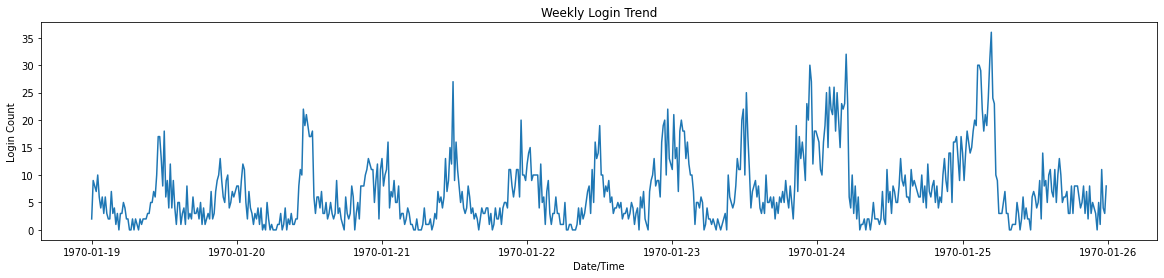

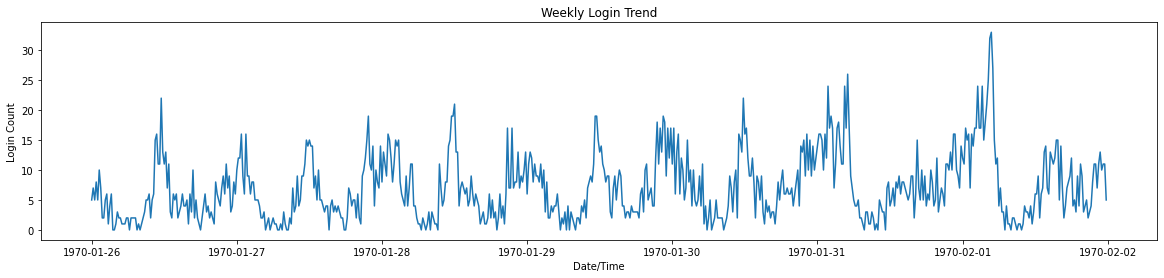

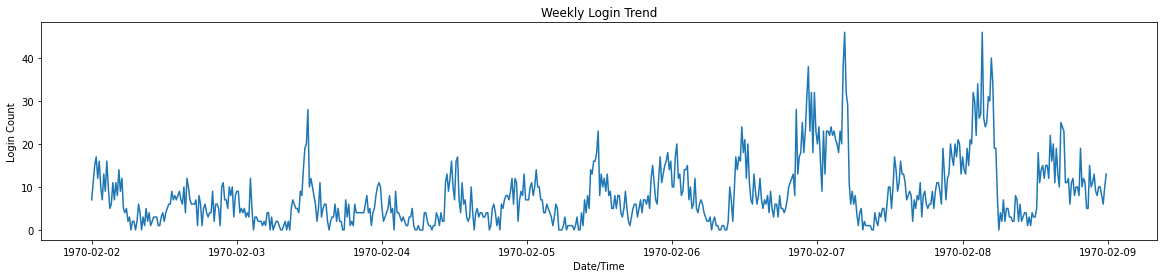

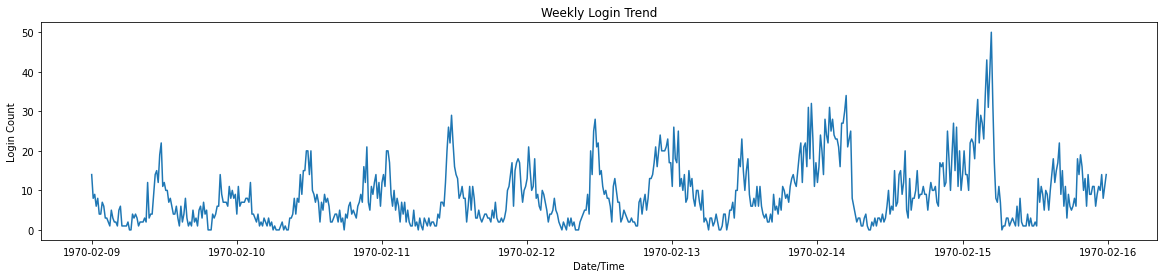

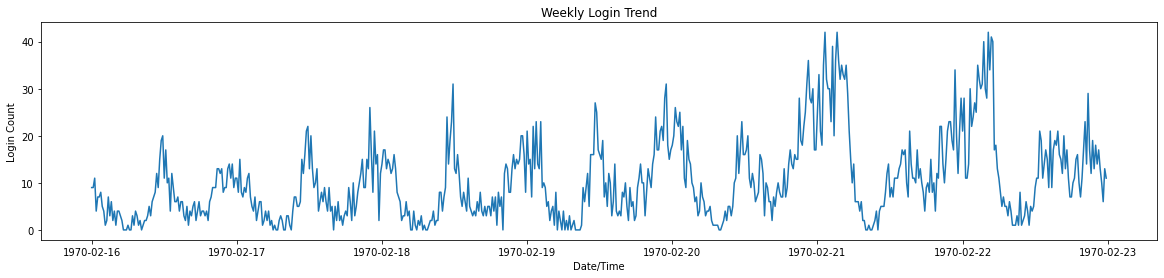

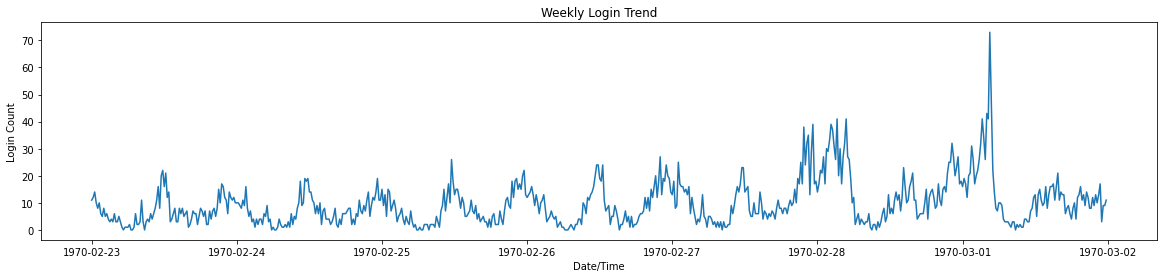

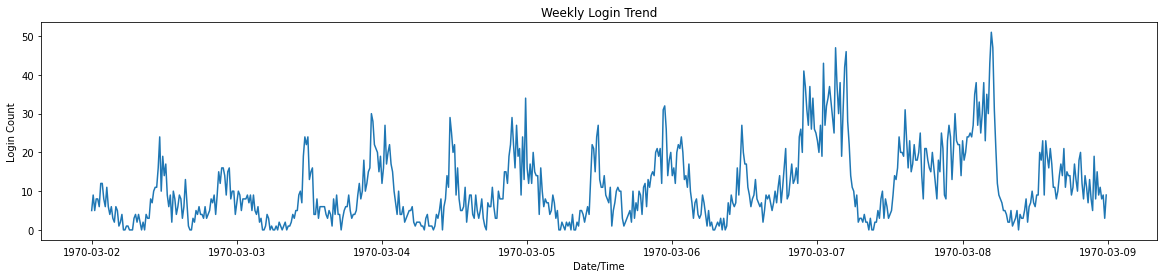

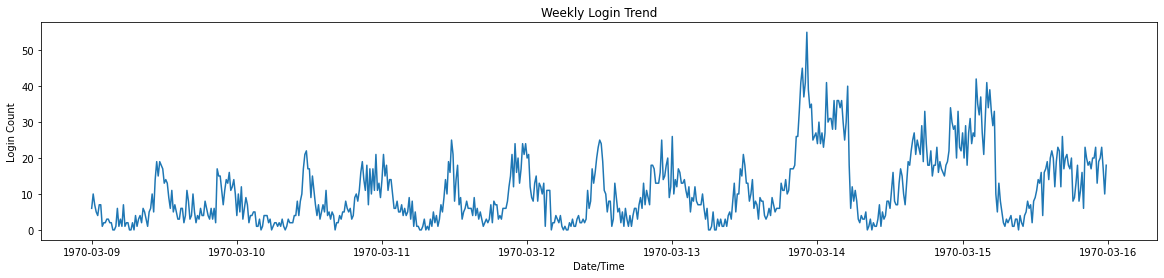

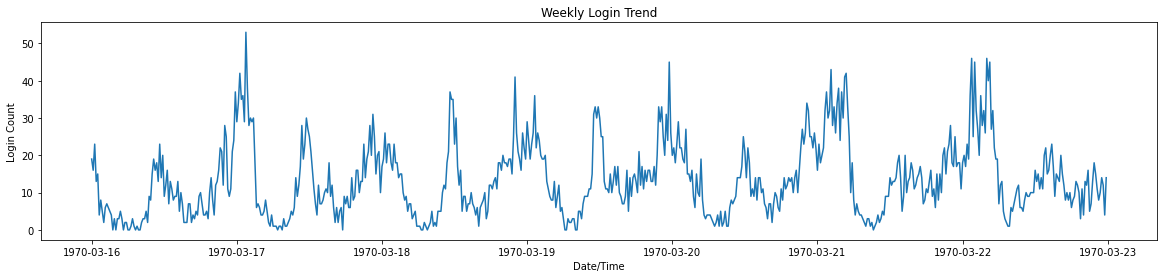

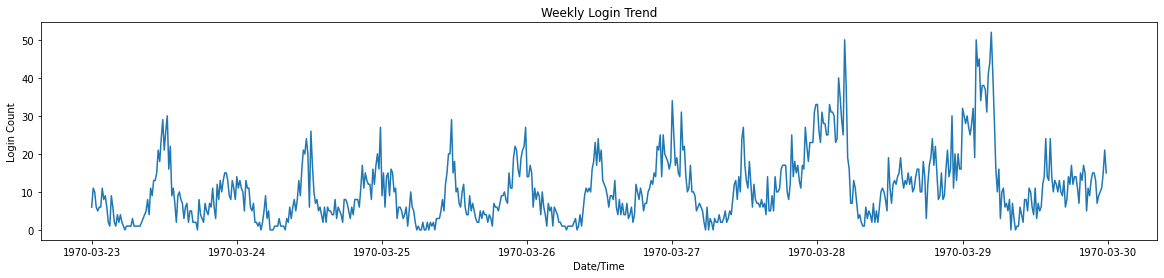

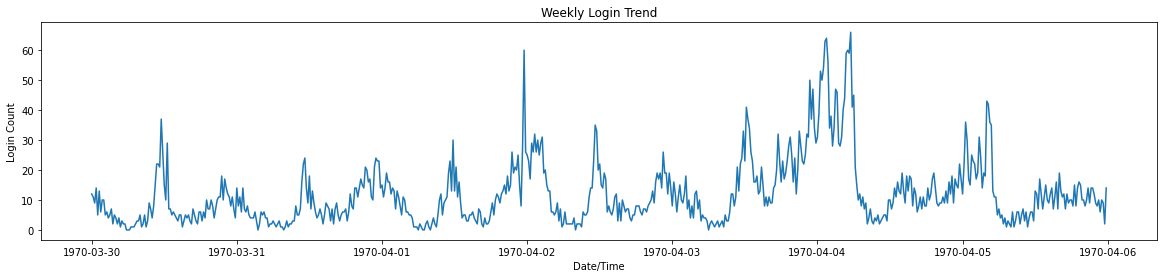

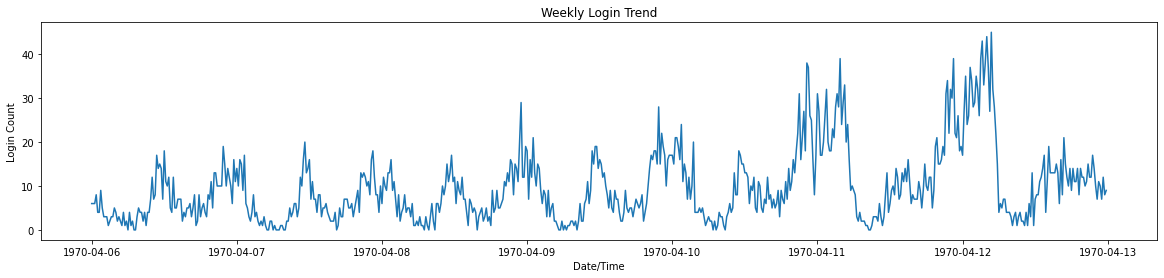

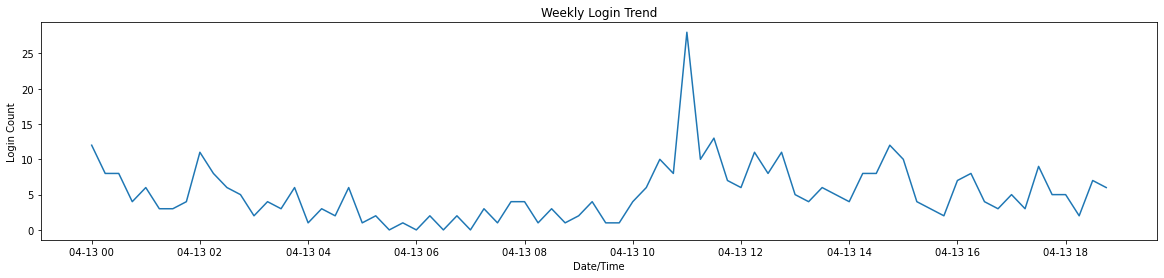

In [15]:
#examine weekly data

#get unique weeks
lst_unique_weeks = data_by_fifteen_mins.login_time.dt.isocalendar().week.unique()

#plot weekly login trends
for week in lst_unique_weeks:
    weekly_data = data_by_fifteen_mins[data_by_fifteen_mins.login_time.dt.isocalendar().week == week]
    plt.figure(figsize=(20,4))
    plt.plot(weekly_data.login_time,weekly_data.login_count);
    label_figure(plt.gca(), 'Weekly Login Trend', 'Date/Time', 'Login Count')

In [16]:
#examine logins by time

#create a time of day column
data_by_fifteen_mins['login_time_of_day'] = data_by_fifteen_mins.login_time.dt.time

In [17]:
#get the data grouped by the login time of day
data_by_time =  data_by_fifteen_mins.groupby('login_time_of_day') \
    .agg({'login_count':'mean'}) \
    .reset_index()

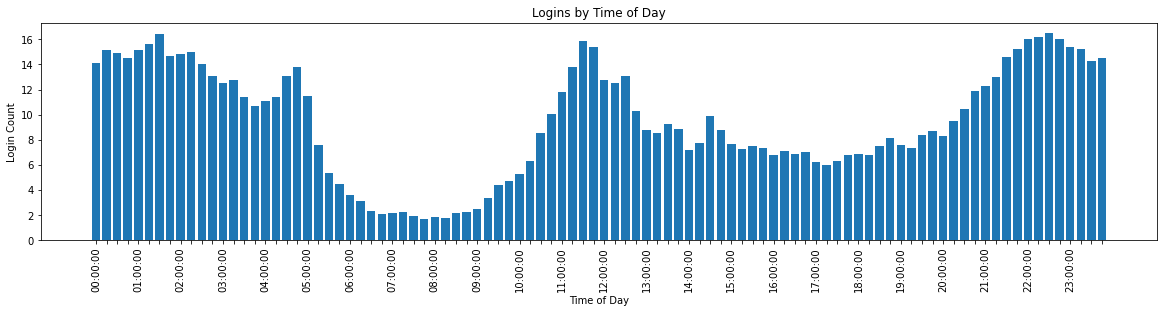

In [18]:
#visualize logins by time of day

#get labels and data for the x axis (since the time of day data is non-numeric)
x_labels = data_by_time.login_time_of_day
x_data = range(len(x_labels))

#plot logins by time of day
plt.figure(figsize=(20,4))
plt.bar(x_data, data_by_time.login_count);
plt.xticks(x_data, x_labels, rotation='vertical');
label_figure(plt.gca(), 'Logins by Time of Day', 'Time of Day', 'Login Count')

#show every 4th tick label
ax = plt.gca()
for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i%4 != 0:
        label.set_visible(False)

In [19]:
#how do the time of day trends differ for weekends vs. weekdays?

#filter for weekends
weekend_mask = data_by_fifteen_mins.login_time.dt.dayofweek.isin([5,6])

#get data for weekends only
weekend_data = data_by_fifteen_mins[weekend_mask]

#get data for weekdays only
weekday_data = data_by_fifteen_mins[~weekend_mask]

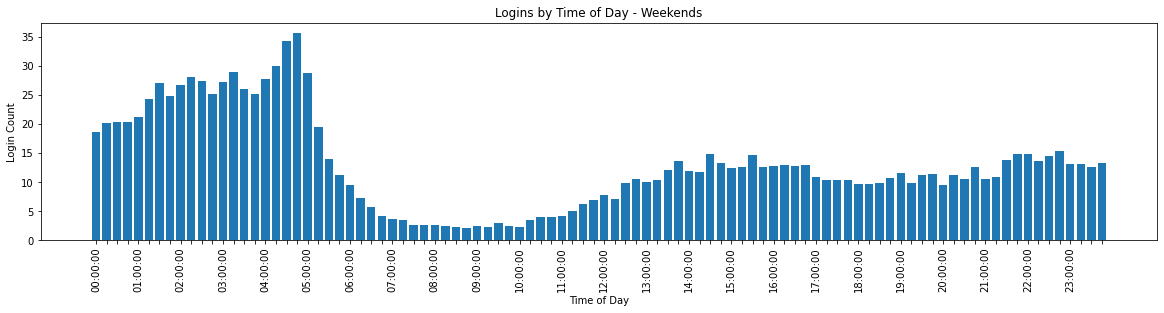

In [20]:
#visualize logins by time of day for weekends

#group the data by 15 minute intervals
weekend_data_by_time = weekend_data.groupby('login_time_of_day') \
    .agg({'login_count':'mean'}) \
    .reset_index()

#get labels and data for the x axis (since the time of day data is non-numeric)
x_labels = weekend_data_by_time.login_time_of_day
x_data = range(len(x_labels))

#plot logins by time of day for weekends
plt.figure(figsize=(20,4))
plt.bar(x_data, weekend_data_by_time.login_count);
plt.xticks(x_data, x_labels, rotation='vertical');
label_figure(plt.gca(), 'Logins by Time of Day - Weekends', 'Time of Day', 'Login Count')

#show every 4th tick label
ax = plt.gca()
for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i%4 != 0:
        label.set_visible(False)

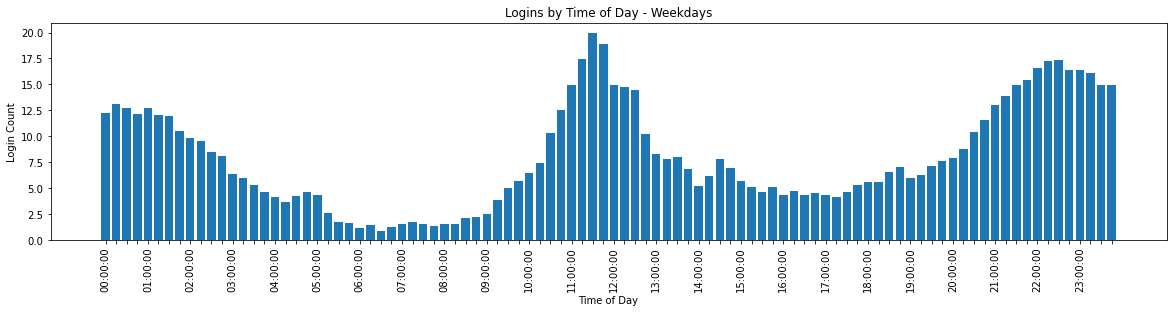

In [21]:
#visualize logins by time of day for weekdays

#group the data by 15 minute intervals
weekday_data_by_time = weekday_data.groupby('login_time_of_day') \
    .agg({'login_count':'mean'}) \
    .reset_index()

#get labels and data for the x axis (since the time of day data is non-numeric)
x_labels = weekday_data_by_time.login_time_of_day
x_data = range(len(x_labels))

#plot logins by time of day for weekdays
plt.figure(figsize=(20,4))
plt.bar(x_data, weekday_data_by_time.login_count);
plt.xticks(x_data, x_labels, rotation='vertical');
label_figure(plt.gca(), 'Logins by Time of Day - Weekdays', 'Time of Day', 'Login Count')

#show every 4th tick label
ax = plt.gca()
for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i%4 != 0:
        label.set_visible(False)